<a href="https://colab.research.google.com/github/Abrazacs/course_work_ml/blob/main/%D0%9A%D1%83%D1%80%D1%81%D0%BE%D0%B2%D0%B0%D1%8F_ML_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F_%D0%A1%D0%A150.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext cuml.accel

The cuml.accel extension is already loaded. To reload it, use:
  %reload_ext cuml.accel


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_excel('Данные_для_курсовои_Классическое_МО.xlsx')
df.dropna(inplace=True)
df.drop(['Unnamed: 0'], axis=1, inplace=True) # убираем индекс
df.drop(['SI', 'IC50, mM'], axis=1, inplace=True) # удаляем таргеты других задач
df = df[df['CC50, mM'] < 2079.43] # удаляем выбросы (см. EDA)
df.head()

,"CC50, mM",MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,175.482382,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,340.300,384.350449,...,0,0,0,0,0,0,0,0,3,0
1,5.402819,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,340.300,388.381750,...,0,0,0,0,0,0,0,0,3,0
2,161.142320,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,388.344,446.458903,...,0,0,0,0,0,0,0,0,3,0
3,107.855654,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,398.679,352.311,398.366099,...,0,0,0,0,0,0,0,0,4,0
4,139.270991,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,466.713,424.377,466.334799,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# создаем датафрейм для хранения результатов
resulst_df = pd.DataFrame(columns=['model_name', 'params', 'train_mse', 'test_mse', 'test_r2', 'test_mae'])

def add_result(model_name, params, train_mse, test_mse, test_r2, test_mae):

  """
  Функция для добавления результатов в датафрейм
  """
  global resulst_df
  new_row = {'model_name': model_name, 'params': params, 'train_mse': -train_mse, 'test_mse': test_mse, 'test_r2': test_r2, 'test_mae': test_mae}
  resulst_df = pd.concat([resulst_df, pd.DataFrame([new_row])], ignore_index=True)

In [ ]:
# создаем словарь моделей
models_config = {
    'KNN': {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'p': [1, 2]
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [3, 4, 5],
            'max_features': ['sqrt', 0.3, 0.5, 0.7]
        }
    },
    'AdaBoost': {
        'model': AdaBoostRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.1, 0.2, 0.3],
            'loss': ['linear', 'square', 'exponential'],
            'estimator': [
                DecisionTreeRegressor(max_depth=1),
                DecisionTreeRegressor(max_depth=2),
                DecisionTreeRegressor(max_depth=3)
            ]
        }
    }
}

[2025-05-29 08:09:07.278] [CUML] [info] Unused keyword parameter: handle during CPU estimator initialization
[2025-05-29 08:09:07.278] [CUML] [info] Unused keyword parameter: verbose during CPU estimator initialization
[2025-05-29 08:09:07.278] [CUML] [info] Unused keyword parameter: output_type during CPU estimator initialization


In [ ]:
X = df.drop(['CC50, mM'], axis=1)
y = df['CC50, mM']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def train_models_and_print_results(models_config, X_train, y_train, X_test, y_test, model_name_postfix=''):

  """
  Функция для обучения моделей и вывода результатов
  """

  for model_name, model_config in models_config.items():

    grid_search = GridSearchCV(estimator= model_config['model'],
                               param_grid=model_config['params'],
                               cv=5,
                               scoring='neg_mean_squared_error')

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    model_name = model_name + model_name_postfix

    add_result(model_name,
               grid_search.best_params_,
               grid_search.best_score_,
               mse,
               r2,
               mae)

    print(f'====================== {model_name} ===========================')
    print(f'Best params: {grid_search.best_params_}')
    print(f'Train MSE: {-grid_search.best_score_}')
    print(f'Test MSE: {mse}')
    print(f'Test R2: {r2}')
    print(f'Test MAE: {mae}')
    print('================================================================\n')


# Без стандартизации

In [ ]:
train_models_and_print_results(models_config, X_train, y_train, X_test, y_test)

[2025-05-29 08:09:07.306] [CUML] [info] Unused keyword parameter: leaf_size during cuML estimator initialization
[2025-05-29 08:09:07.306] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-05-29 08:09:07.307] [CUML] [info] Unused keyword parameter: leaf_size during cuML estimator initialization
[2025-05-29 08:09:07.307] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-05-29 08:09:07.591] [CUML] [info] Unused keyword parameter: leaf_size during cuML estimator initialization
[2025-05-29 08:09:07.591] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-05-29 08:09:07.606] [CUML] [info] Unused keyword parameter: leaf_size during cuML estimator initialization
[2025-05-29 08:09:07.606] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-05-29 08:09:07.618] [CUML] [info] Unused keyword parameter: leaf_size during cuML estimator initializa

# Добавляем стандартизацию

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

train_models_and_print_results(models_config, X_train_scaled, y_train, X_test_scaled, y_test, ' + StandardScaler')

====================== KNN + StandardScaler ===========================
Best params: {'algorithm': 'auto', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
Train MSE: 140409.8974010557
Test MSE: 113157.23685161666
Test R2: 0.4468078272608432
Test MAE: 242.94390477389356

====================== RandomForest + StandardScaler ===========================
Best params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Train MSE: 131591.83890058735
Test MSE: 103546.21453746913
Test R2: 0.49379326508290355
Test MAE: 251.06058460588915

====================== AdaBoost + StandardScaler ===========================
Best params: {'estimator': DecisionTreeRegressor(max_depth=3), 'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 50}
Train MSE: 156597.40518579137
Test MSE: 139399.05616213995
Test R2: 0.3185193549994304
Test MAE: 328.2978002733673



# Используем FeatureSelection + StandardScaler

In [ ]:
feature_selection = SelectKBest(score_func=mutual_info_regression, k=15)

X_train_selected = feature_selection.fit_transform(X_train_scaled, y_train)
X_test_selected = feature_selection.transform(X_test_scaled)

train_models_and_print_results(models_config, X_train_selected, y_train, X_test_selected, y_test, ' + StandardScaler + SelectKbest')

====================== KNN + StandardScaler + SelectKbest ===========================
Best params: {'algorithm': 'auto', 'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}
Train MSE: 190581.0300065812
Test MSE: 149511.95488281432
Test R2: 0.2690803922637389
Test MAE: 302.46750623727195

====================== RandomForest + StandardScaler + SelectKbest ===========================
Best params: {'max_depth': 30, 'max_features': 0.7, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}
Train MSE: 156538.308560692
Test MSE: 122754.47966196667
Test R2: 0.39988975334636045
Test MAE: 270.8255887856397

====================== AdaBoost + StandardScaler + SelectKbest ===========================
Best params: {'estimator': DecisionTreeRegressor(max_depth=3), 'learning_rate': 0.1, 'loss': 'linear', 'n_estimators': 50}
Train MSE: 193956.55279453643
Test MSE: 179768.35461919618
Test R2: 0.12116582687556499
Test MAE: 374.92923646505295



# Итоги

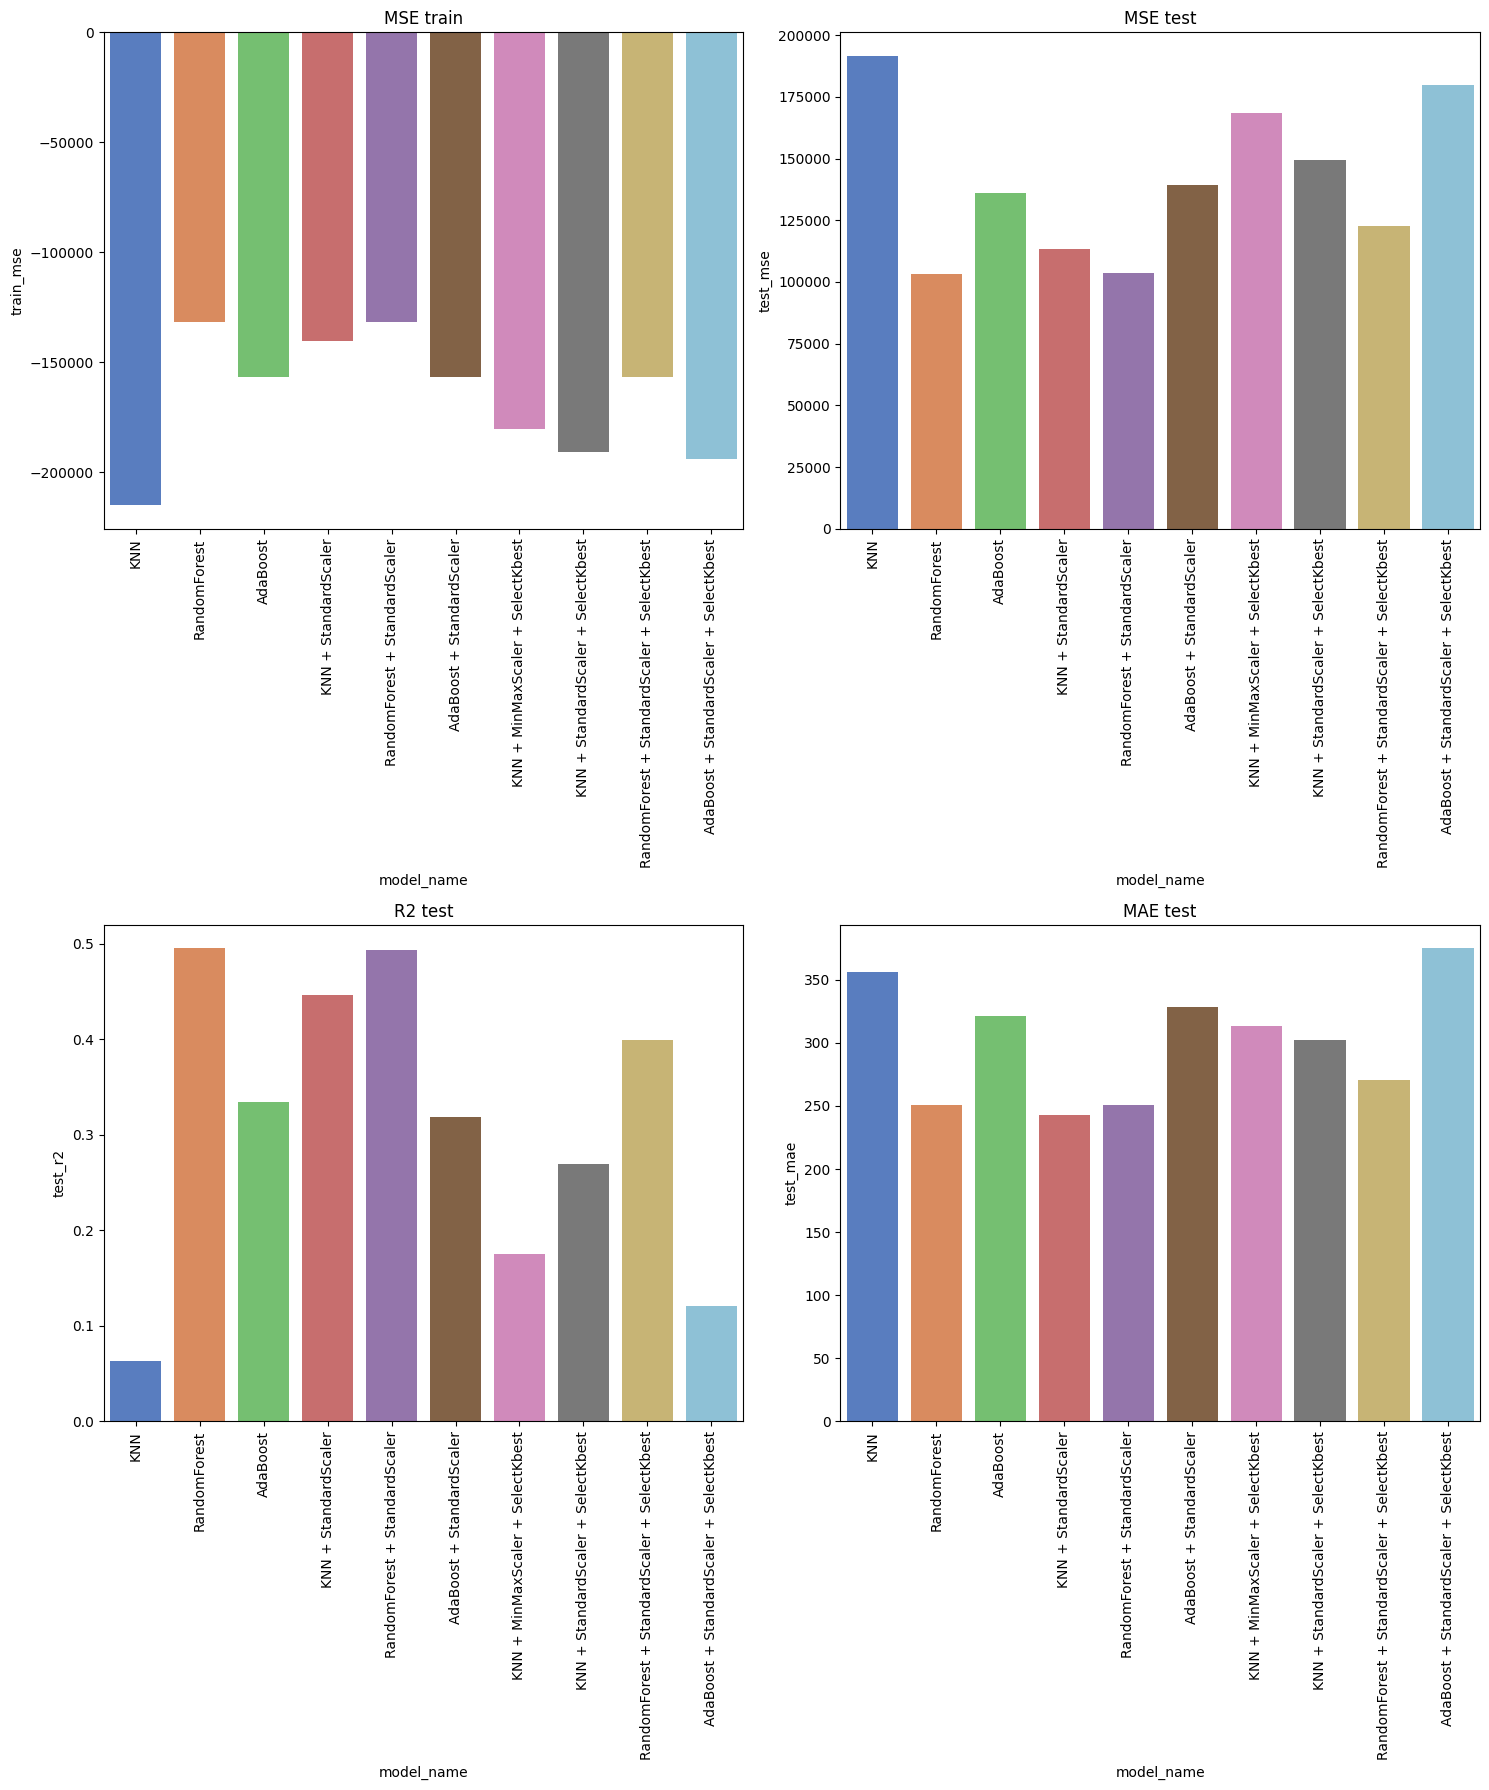

In [ ]:
x_column = 'model_name'
y_column_name_map = {
    'MSE train': 'train_mse',
    'MSE test': 'test_mse',
    'R2 test': 'test_r2',
    'MAE test': 'test_mae'
}

def draw_comparing_score_barplot(x, y_col, title, i_idx, j_idx, df, axes):
  sns.barplot(x=x, y=y_col, data=df, ax=axes[i_idx, j_idx], palette='muted')
  axes[i_idx, j_idx].set_title(title)
  axes[i_idx, j_idx].tick_params(axis='x', rotation=90)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 18))

for idx, (title, y_col) in enumerate(y_column_name_map.items()):
  i_idx = idx // 2
  j_idx = idx % 2
  draw_comparing_score_barplot(x_column, y_col, title, i_idx, j_idx, resulst_df, axes)

plt.tight_layout()
plt.show()